In this approach we will make almost everything the same as in kmeans+svm

Except for the fact that we will undersample our data, so there will be no class imbalance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC

%matplotlib inline
np.random.seed(59)

# set the max columns to none
pd.set_option('display.max_columns', None)

In [2]:
train_path = 'D:\\machine learning\\ml projects\\Main Pet Project for May-June 2022\\Customer Churn Prediction\\featured_data\\train.csv'

df = pd.read_csv(train_path)
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,state_MD,state_MN,state_NJ,state_TX,state_WV,state_other,avg_mt_minutes,avg_mt_calls,avg_mt_charge,avg_call_charge,avg_intl_call_charge,avg_call_minutes,avg_intl_call_minutes,both_plans
0,107,0,1,26,13.7,3,3.70,1,0,611.5,329,55.54,0,1,0,0,0,0,0,0,1,5.714953,3.074766,0.519065,0.168815,1.233333,1.858663,4.566667,0
1,137,0,0,0,12.2,5,3.29,0,0,527.2,328,59.00,0,1,0,0,0,1,0,0,0,3.848175,2.394161,0.430657,0.179878,0.658000,1.607317,2.440000,0
2,84,1,0,0,6.6,7,1.78,2,0,558.2,248,65.02,1,0,0,0,0,0,0,0,1,6.645238,2.952381,0.774048,0.262177,0.254286,2.250806,0.942857,0
3,75,1,0,0,10.1,3,2.73,3,0,501.9,356,49.36,0,1,0,0,0,0,0,0,1,6.692000,4.746667,0.658133,0.138652,0.910000,1.409831,3.366667,0
4,121,0,1,24,7.5,7,2.03,3,0,779.3,314,76.28,0,0,1,0,0,0,0,0,1,6.440496,2.595041,0.630413,0.242930,0.290000,2.481847,1.071429,0


In [3]:
# smth = df.sample(frac=5, random_state=59)
# print(smth)

In [4]:
# Shuffle the Dataset
shuffled_df = df.sample(frac=1, random_state=59)

# Put all the fraud class in a separate dataset
churn_df = shuffled_df.loc[shuffled_df['churn'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_churn_df = shuffled_df.loc[shuffled_df['churn'] == 0].sample(n=churn_df.shape[0], random_state=59)

# Concatenate both dataframes again
normalized_df = pd.concat([churn_df, non_churn_df])

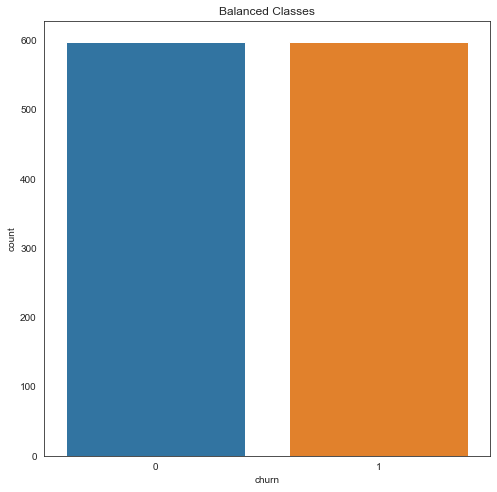

In [5]:
# Plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.set_style('white')
sns.countplot(x='churn', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [6]:
X = normalized_df.drop('churn', axis=1)
y = normalized_df['churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=59)

In [7]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_val_st = st_scaler.transform(X_val)

In [8]:
km_list = list()

for i in range(1, 30):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=59)
    km = km.fit(X_train_st)
    
    km_list.append(pd.Series({'clusters': i, 
                              'inertia': km.inertia_,
                              'model': km}))

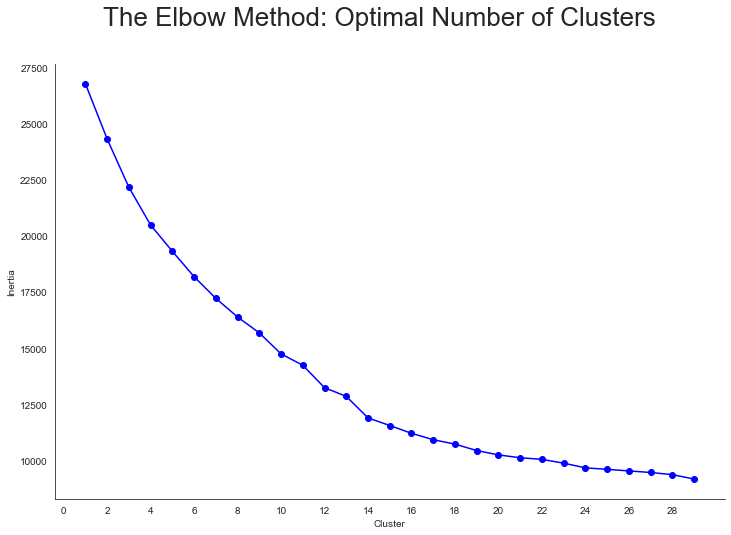

In [9]:
k = pd.concat(km_list, axis=1).T[['clusters','inertia']]

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')

plt.plot(k['clusters'], k['inertia'], 'bo-')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top','right']:
    ax.spines[i].set_visible(False)

ax.set_xticks(range(0, 30, 2))
ax.set(xlabel='Cluster', ylabel='Inertia')

plt.suptitle('The Elbow Method: Optimal Number of Clusters', size=26)
plt.show()

13 is enough

In [10]:
kmeans = KMeans(n_clusters=13, max_iter=300, n_init=10, random_state=59)
kmeans.fit(X_train_st)

predicted_clusters_train = kmeans.predict(X_train_st)
X_train_st = np.column_stack((X_train_st, predicted_clusters_train))

predicted_clusters_val = kmeans.predict(X_val_st)
X_val_st = np.column_stack((X_val_st, predicted_clusters_val))

In [11]:
svm = SVC()
svm.fit(X_train_st, y_train)
y_pred = svm.predict(X_val_st)

In [12]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_val, y_pred))
print('F1 Score', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       121
           1       0.85      0.78      0.82       119

    accuracy                           0.82       240
   macro avg       0.83      0.82      0.82       240
weighted avg       0.83      0.82      0.82       240

F1 Score 0.8157894736842106


F1 Score = 0.82

Now we will try something more sophisticated like SMOTE (for oversampling instead of undersampling)